
# Unified (Numerical ➜ Classification): MLP **or** RNN → SHAP → STAT‑XAI

This notebook handles **numerical-only** loan data with a **binary** target.  
Workflow (identical for both models):
1. Data prep: drop index col, **clip outliers** (train-based bounds), **scale** features
2. Train either **MLP** (scikit-learn) or **RNN** (PyTorch treating features as a short sequence)
3. Predict → merge predictions with original test features
4. **SHAP** explanations
5. **STAT‑XAI**: main effects (point‑biserial), pairwise (logit with interaction), final scores
6. Save tables and plots for **main**, **pairwise**, and **final** effects


In [ ]:

# If needed, uncomment to install
# !pip install -q pandas numpy scikit-learn matplotlib shap scipy psutil statsmodels torch --index-url https://download.pytorch.org/whl/cpu


In [1]:

from __future__ import annotations

import os
import logging
import itertools
from typing import Dict, List, Sequence, Set, Tuple

import numpy as np
import pandas as pd
import psutil
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.neural_network import MLPClassifier

import shap

# PyTorch bits for the RNN branch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader



pd.set_option("display.max_columns", 200)
logging.basicConfig(level=logging.INFO, format="%(levelname)s | %(message)s")


## Configuration

In [2]:

# =============== User Config ===============
MODEL = "MLP"   # <-- set to "MLP" or "RNN"

DATA_PATH = "/Numerical Loan Approval Synthetic Dataset with binary outcome.csv"  # update to your path
TARGET = "Loan_Approval"

TEST_SIZE = 0.20
RANDOM_STATE = 42
THRESHOLD = 0.5
ALPHA = 0.05  # significance for tests

# Outlier clipping quantiles (train bounds)
LOW_Q, HIGH_Q = 0.01, 0.95

# SHAP
SHAP_BATCH_SIZE = 2000   # for MLP batching
SHAP_PLOT_SAMPLE = 1200  # subsample for plots

# RNN
EPOCHS = 60
BATCH_TRAIN = 64
BATCH_TEST = 256
RNN_HIDDEN = 32
RNN_LAYERS = 1

# Output dirs
OUTPUT_DIR = "outputs_numeric"
PLOTS_DIR  = os.path.join(OUTPUT_DIR, "plots")
TABLES_DIR = os.path.join(OUTPUT_DIR, "tables")
SHAP_DIR   = os.path.join(OUTPUT_DIR, "shap")
for d in [OUTPUT_DIR, PLOTS_DIR, TABLES_DIR, SHAP_DIR]:
    os.makedirs(d, exist_ok=True)

print("MODEL:", MODEL)
print("Saving under:", OUTPUT_DIR)


MODEL: MLP
Saving under: outputs_numeric


## Helpers

In [35]:

def clip_outliers(df: pd.DataFrame, lower_quantile=0.01, upper_quantile=0.99, ref_bounds=None):
    """Clip numeric columns using train-based quantile bounds. Returns (clipped_df, bounds_dict)."""
    df_clipped = df.copy()
    bounds = {} if ref_bounds is None else dict(ref_bounds)
    for col in df.columns:
        if ref_bounds is None:
            lower = df[col].quantile(lower_quantile)
            upper = df[col].quantile(upper_quantile)
            bounds[col] = (lower, upper)
        else:
            lower, upper = bounds[col]
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped, bounds


# def stat_xai_numeric(merged_df: pd.DataFrame, model_suffix: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
#     """STAT‑XAI for numeric features:
#     - Main: point-biserial r_pb (set to 0 if p>=ALPHA)
#     - Pairwise: logistic regression with interaction term; effect size = odds ratio of interaction (sum per-feature)
#     - Final score: main + sum_interactions
#     Also saves CSVs and bar plots for main, pairwise (top-15), and final.
#     """
#     # Numerical columns excluding label

#     numerical_cols = [c for c in merged_df.select_dtypes(include=[np.number]).columns if c != 'Predicted_Label']
    
#     alpha = 0.05
    
#     # === 1) MAIN EFFECTS via Point-Biserial Correlation ===
#     individual = []
#     main_effects = {}
    
#     for feat in numerical_cols:
#         r_pb, p_val = pointbiserialr(merged_df[feat], merged_df['Predicted_Label'])
#         effect = r_pb if p_val < alpha else 0.0
#         main_effects[feat] = effect
#         individual.append({
#             'Feature': feat,
#             'Main p-value': round(p_val, 4),
#             'Main Effect (r_pb)': round(effect, 4)
#         })
    
#     main_df = pd.DataFrame(individual)
#     print(main_df)
    
#     # === 2) PAIRWISE INTERACTIONS via Logistic Regression ===
#     pair_effects = {feat: 0.0 for feat in numerical_cols}
#     interaction_details = []
    
#     for x, y in itertools.combinations(numerical_cols, 2):
#         formula = f"Predicted_Label ~ {x} * {y}"
#         model = smf.logit(formula, merged_df).fit(disp=False)
#         interaction_term = f"{x}:{y}"
#         p_int = model.pvalues.get(interaction_term, np.nan)
#         coef_int = model.params.get(interaction_term, np.nan)
#         odds_ratio = np.exp(coef_int) if not np.isnan(coef_int) else np.nan
#         significant = (p_int < alpha) if not np.isnan(p_int) else False
    
#         interaction_details.append({
#             'Feature Pair':        f"{x} × {y}",
#             'Interaction p-value': round(p_int, 4),
#             'Effect Size (OR)':    round(odds_ratio, 4),
#             'Significant?':        'Yes' if significant else 'No'
#         })
#         if significant:
#             pair_effects[x] += odds_ratio
#             pair_effects[y] += odds_ratio
    
#     pairwise_df = pd.DataFrame(interaction_details)
#     print(pairwise_df)
    
#     # === 3) FINAL COMPOSITE SCORES ===
#     results = []
#     for feat in numerical_cols:
#         sum_int = pair_effects[feat]
#         main_eff = main_effects.get(feat, 0.0)
#         results.append({
#             'Feature':               feat,
#             'Main Effect (r_pb)':    round(main_eff, 4),
#             'Sum Interaction (ORs)': round(sum_int, 4),
#             'Final Score':           round(main_eff + sum_int, 4)
#         })
    
#     final_df = pd.DataFrame(results)
#     print(final_df)
#     # ---------------- Plots ----------------
#     # Main
#     if not main_df.empty:
#         df_sorted = main_df.sort_values('Main Effect (r_pb)', ascending=False)
#         plt.figure()
#         plt.bar(df_sorted['Feature'], df_sorted['Main Effect (r_pb)'])
#         plt.xticks(rotation=45, ha='right'); plt.ylabel('Point-biserial r')
#         plt.title(f'{model_suffix}: Main Effects (Descending)')
#         plt.tight_layout()
#         plt.savefig(os.path.join(PLOTS_DIR, f"main_effects_bar_{model_suffix}.png"), dpi=300)
#         plt.show()

#     # Pairwise (top-15)
#     if not pairwise_df.empty and 'Effect Size (OR)' in pairwise_df:
#         df_sorted = (pairwise_df.dropna(subset=['Effect Size (OR)'])
#                                    .sort_values('Effect Size (OR)', ascending=False)
#                                    .head(15))
#         if not df_sorted.empty:
#             plt.figure()
#             plt.bar(df_sorted['Feature Pair'], df_sorted['Effect Size (OR)'])
#             plt.xticks(rotation=60, ha='right'); plt.ylabel('Odds Ratio (interaction)')
#             plt.title(f'{model_suffix}: Top Pairwise Effects (Descending)')
#             plt.tight_layout()
#             plt.savefig(os.path.join(PLOTS_DIR, f"pairwise_effects_bar_{model_suffix}.png"), dpi=300)
#             plt.show()

#     # Final
#     if not final_df.empty:
#         df_sorted = final_df.sort_values('Final Score', ascending=False)
#         plt.figure()
#         plt.bar(df_sorted['Feature'], df_sorted['Final Score'])
#         plt.xticks(rotation=45, ha='right'); plt.ylabel('Final Score (main + sum ORs)')
#         plt.title(f'{model_suffix}: Final Scores (Descending)')
#         plt.tight_layout()
#         plt.savefig(os.path.join(PLOTS_DIR, f"final_effects_bar_{model_suffix}.png"), dpi=300)
#         plt.show()

#     return main_df, pairwise_df, final_df


## Load, Clip, Scale, Split

In [7]:

df = pd.read_csv(DATA_PATH)
# Drop an accidental index column
if df.columns[0].lower() in {"unnamed: 0", "index", "id"}:
    df = df.drop(df.columns[0], axis=1)
assert TARGET in df.columns, f"Target '{TARGET}' not found: {df.columns.tolist()}"

X = df.drop(TARGET, axis=1)
y = df[TARGET]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Save original (unscaled) test for reporting
X_test_original = X_test.copy()

# Outlier clipping on train, then apply same bounds to test
X_train_clip, bounds = clip_outliers(X_train, lower_quantile=LOW_Q, upper_quantile=HIGH_Q, ref_bounds=None)
X_test_clip, _ = clip_outliers(X_test, lower_quantile=LOW_Q, upper_quantile=HIGH_Q, ref_bounds=bounds)

# Scale
scaler = StandardScaler().fit(X_train_clip)
X_train_scaled = scaler.transform(X_train_clip)
X_test_scaled  = scaler.transform(X_test_clip)

num_features = X.columns.tolist()
display(df.head())
print("Shapes:", X_train.shape, X_test.shape)


,Annual_Income,Credit_Score,Debt_to_Income,Employment_Length,Age,Loan_Approval
0,65581.311290,505.502450,0.729998,12.762891,73,0
1,120317.859109,483.101653,0.184512,9.185849,38,1
2,99539.424472,396.884652,0.346640,19.289970,18,0
3,86872.555999,633.996669,0.663281,4.379569,69,1
4,44821.770842,562.143288,0.482089,11.757128,20,0


Shapes: (8000, 5) (2000, 5)


## Train & Predict (Choose MLP or RNN)

In [9]:

if MODEL.upper() == "MLP":
    clf = MLPClassifier(
        hidden_layer_sizes=(128,64,32,16),
        random_state=RANDOM_STATE, max_iter=500, activation='relu',
        solver='adam', alpha=1e-4, batch_size=64, learning_rate='constant', learning_rate_init=1e-4
    ).fit(X_train_scaled, y_train)

    probs = clf.predict_proba(X_test_scaled)[:, 1]
    y_pred = (probs > THRESHOLD).astype(int)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, probs)
    print(f"MLP Test Accuracy @ {THRESHOLD:.2f}: {acc:.4f}")
    print(f"MLP Test ROC AUC              : {auc:.4f}")

    merged_df = X_test_original.reset_index(drop=True).copy()
    merged_df['Predicted_Label'] = y_pred
    merged_df['Predicted_Prob']  = probs
    merged_df = merged_df.iloc[:, :-1]
    merged_df.to_csv(os.path.join(TABLES_DIR, "test_predictions_merged_MLP_num.csv"), index=False)

    MODEL_SUFFIX = "MLP_num"


MLP Test Accuracy @ 0.50: 0.9925
MLP Test ROC AUC              : 0.9998


In [ ]:

if MODEL.upper() == "RNN":
    # Treat each feature as a timestep with 1-d input
    class NumDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.from_numpy(X).float().unsqueeze(-1)  # [N, F, 1]
            self.y = torch.from_numpy(np.asarray(y)).float().unsqueeze(1)  # [N, 1]
        def __len__(self): return len(self.X)
        def __getitem__(self, idx): return self.X[idx], self.y[idx]

    train_dl = DataLoader(NumDataset(X_train_scaled, y_train.values), batch_size=BATCH_TRAIN, shuffle=True)
    test_dl  = DataLoader(NumDataset(X_test_scaled,  y_test.values),  batch_size=BATCH_TEST)

    class NumRNNClassifier(nn.Module):
        def __init__(self, input_size=1, hidden_size=RNN_HIDDEN, num_layers=RNN_LAYERS):
            super().__init__()
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
            self.fc  = nn.Linear(hidden_size, 1)
        def forward(self, x):
            _, h_n = self.rnn(x)            # h_n: [num_layers, B, hidden]
            last_h = h_n[-1]                # [B, hidden]
            return self.fc(last_h)          # logits [B,1]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = NumRNNClassifier().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    for epoch in range(1, EPOCHS+1):
        model.train(); tot = 0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
        if epoch % 10 == 0 or epoch == 1:
            print(f"Epoch {epoch:02d} | Train Loss = {tot/len(train_dl.dataset):.4f}")

    # Evaluate
    model.eval(); probs_list, preds_list, trues_list = [], [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            p = torch.sigmoid(model(xb)).cpu().numpy().flatten()
            probs_list.extend(p)
            preds_list.extend((p > THRESHOLD).astype(int))
            trues_list.extend(yb.numpy().flatten().astype(int))

    probs = np.array(probs_list)
    y_pred = np.array(preds_list)

    acc = accuracy_score(trues_list, preds_list)
    auc = roc_auc_score(trues_list, probs)
    print(f"RNN Test Accuracy @ {THRESHOLD:.2f}: {acc:.4f}")
    print(f"RNN Test ROC AUC              : {auc:.4f}")

    merged_df = X_test_original.reset_index(drop=True).copy()
    merged_df['Predicted_Label'] = y_pred
    merged_df['Predicted_Prob']  = probs
    merged_df.to_csv(os.path.join(TABLES_DIR, "test_predictions_merged_RNN_num.csv"), index=False)

    MODEL_SUFFIX = "RNN_num"


## SHAP (based on selected model)

INFO | Computing SHAP for MLP...
INFO | MLP SHAP 0-2000 | RAM ~ 3.90 GB


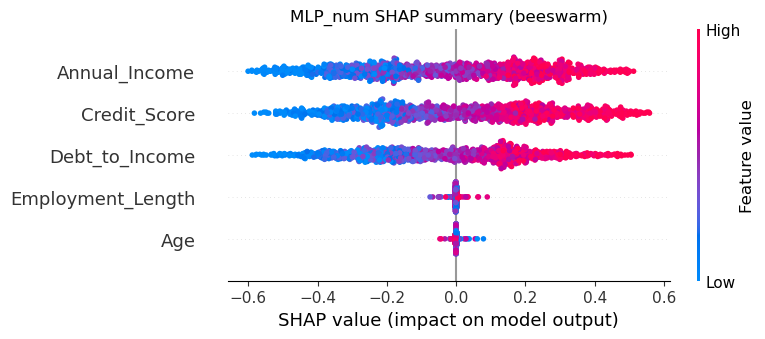

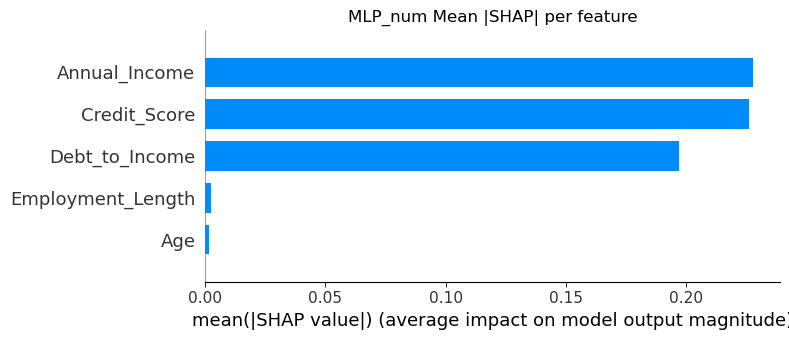

In [11]:

if MODEL_SUFFIX == "MLP_num":
    logging.info("Computing SHAP for MLP...")
    explainer = shap.Explainer(lambda x: clf.predict_proba(x)[:, 1], X_train_scaled)
    all_vals = []
    n = X_test_scaled.shape[0]
    for start in range(0, n, SHAP_BATCH_SIZE):
        end = min(start + SHAP_BATCH_SIZE, n)
        Xb = X_test_scaled[start:end]
        mem = psutil.virtual_memory()
        logging.info(f"MLP SHAP {start}-{end} | RAM ~ {mem.available/1e9:.2f} GB")
        sv = explainer(Xb)
        all_vals.append(sv.values)
    shap_values = np.vstack(all_vals)
    np.save(os.path.join(SHAP_DIR, f"shap_values_{MODEL_SUFFIX}.npy"), shap_values)

    # Plots
    k = min(SHAP_PLOT_SAMPLE, shap_values.shape[0])
    idx = np.random.default_rng(7).choice(shap_values.shape[0], size=k, replace=False)
    X_plot = pd.DataFrame(X_test_scaled[idx], columns=num_features)
    try:
        shap.summary_plot(shap_values[idx], X_plot, show=False)
        plt.title(f"{MODEL_SUFFIX} SHAP summary (beeswarm)"); plt.tight_layout()
        plt.savefig(os.path.join(SHAP_DIR, f"shap_summary_beeswarm_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
    except Exception as e:
        logging.warning(f"Beeswarm failed: {e}")
    try:
        shap.summary_plot(shap_values[idx], X_plot, feature_names=num_features, plot_type="bar", show=False)
        plt.title(f"{MODEL_SUFFIX} Mean |SHAP| per feature"); plt.tight_layout()
        plt.savefig(os.path.join(SHAP_DIR, f"shap_summary_bar_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
    except Exception as e:
        logging.warning(f"Bar failed: {e}")

elif MODEL_SUFFIX == "RNN_num":
    logging.info("Computing SHAP for RNN (DeepExplainer)...")
    # Build tensors
    X_train_tensor = torch.from_numpy(X_train_scaled).float().unsqueeze(-1).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    X_test_tensor  = torch.from_numpy(X_test_scaled).float().unsqueeze(-1).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    # background subset
    bg_size = min(512, X_train_tensor.size(0))
    bg_idx = torch.randperm(X_train_tensor.size(0))[:bg_size]
    background = X_train_tensor[bg_idx]

    # explain subset for plotting
    k = min(SHAP_PLOT_SAMPLE, X_test_tensor.size(0))
    test_idx = torch.randperm(X_test_tensor.size(0))[:k]
    X_explain = X_test_tensor[test_idx]

    deepexplainer = shap.DeepExplainer(model, background)
    sv = deepexplainer.shap_values(X_explain)
    shap_values = sv[0] if isinstance(sv, list) else sv
    shap_values_np = shap_values if isinstance(shap_values, np.ndarray) else shap_values.cpu().numpy()
    np.save(os.path.join(SHAP_DIR, f"shap_values_{MODEL_SUFFIX}.npy"), shap_values_np)

    # summary_plot expects numpy 2D (samples × features); flatten sequence dim
    X_explain_np = X_explain.detach().cpu().numpy().squeeze(-1)  # [N, F]

    try:
        shap.summary_plot(shap_values_np, X_explain_np, feature_names=num_features, show=False)
        plt.title(f"{MODEL_SUFFIX} SHAP summary (beeswarm)"); plt.tight_layout()
        plt.savefig(os.path.join(SHAP_DIR, f"shap_summary_beeswarm_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
    except Exception as e:
        logging.warning(f"RNN beeswarm failed: {e}")
    try:
        shap.summary_plot(shap_values_np, X_explain_np, feature_names=num_features, plot_type="bar", show=False)
        plt.title(f"{MODEL_SUFFIX} Mean |SHAP| per feature"); plt.tight_layout()
        plt.savefig(os.path.join(SHAP_DIR, f"shap_summary_bar_{MODEL_SUFFIX}.png"), dpi=300); plt.show()
    except Exception as e:
        logging.warning(f"RNN bar failed: {e}")


In [17]:
merged_df

,Annual_Income,Credit_Score,Debt_to_Income,Employment_Length,Age,Predicted_Label,Predicted_Prob
0,67475.246464,312.187745,0.494432,14.671350,71,0,1.733886e-16
1,117091.820296,492.095698,0.313057,15.026094,34,1,9.999994e-01
2,47022.069089,473.131099,0.319757,17.294459,62,0,9.686332e-18
3,105710.012881,707.597189,0.461066,6.493326,62,1,1.000000e+00
4,43871.996833,577.220904,0.815222,13.338077,56,0,1.470549e-06
...,...,...,...,...,...,...,...
1995,41435.924203,692.127349,0.709682,5.326703,20,1,8.195387e-01
1996,114526.154078,319.695112,0.464139,18.354193,65,0,7.787638e-07
1997,107054.933799,343.531742,0.065272,13.201095,79,0,1.063569e-14
1998,102370.828181,484.752615,0.869774,10.582374,49,1,1.000000e+00


In [39]:
numerical_cols = [c for c in merged_df.select_dtypes(include=[np.number]).columns if c != 'Predicted_Label']

alpha = 0.05

# === 1) MAIN EFFECTS via Point-Biserial Correlation ===
individual = []
main_effects = {}

for feat in numerical_cols:
    r_pb, p_val = pointbiserialr(merged_df[feat], merged_df['Predicted_Label'])
    effect = r_pb if p_val < alpha else 0.0
    main_effects[feat] = effect
    individual.append({
        'Feature': feat,
        'Main p-value': round(p_val, 4),
        'Main Effect (r_pb)': round(effect, 4)
    })

main_df = pd.DataFrame(individual)
print(main_df)

# === 2) PAIRWISE INTERACTIONS via Logistic Regression ===
pair_effects = {feat: 0.0 for feat in numerical_cols}
interaction_details = []

for x, y in itertools.combinations(numerical_cols, 2):
    formula = f"Predicted_Label ~ {x} * {y}"
    model = smf.logit(formula, merged_df).fit(disp=False)
    interaction_term = f"{x}:{y}"
    p_int = model.pvalues.get(interaction_term, np.nan)
    coef_int = model.params.get(interaction_term, np.nan)
    odds_ratio = np.exp(coef_int) if not np.isnan(coef_int) else np.nan
    significant = (p_int < alpha) if not np.isnan(p_int) else False

    interaction_details.append({
        'Feature Pair':        f"{x} × {y}",
        'Interaction p-value': round(p_int, 4),
        'Effect Size (OR)':    round(odds_ratio, 4),
        'Significant?':        'Yes' if significant else 'No'
    })
    if significant:
        pair_effects[x] += odds_ratio
        pair_effects[y] += odds_ratio

pairwise_df = pd.DataFrame(interaction_details)
print(pairwise_df)

# === 3) FINAL COMPOSITE SCORES ===
results = []
for feat in numerical_cols:
    sum_int = pair_effects[feat]
    main_eff = main_effects.get(feat, 0.0)
    results.append({
        'Feature':               feat,
        'Main Effect (r_pb)':    round(main_eff, 4),
        'Sum Interaction (ORs)': round(sum_int, 4),
        'Final Score':           round(main_eff + sum_int, 4)
    })

final_df = pd.DataFrame(results)
print(final_df)

             Feature  Main p-value  Main Effect (r_pb)
0      Annual_Income        0.0000              0.4865
1       Credit_Score        0.0000              0.4794
2     Debt_to_Income        0.0000              0.4157
3  Employment_Length        0.5114              0.0000
4                Age        0.1116              0.0000
                         Feature Pair  Interaction p-value  Effect Size (OR)  \
0        Annual_Income × Credit_Score               0.7256            1.0000   
1      Annual_Income × Debt_to_Income               0.2958            1.0000   
2   Annual_Income × Employment_Length               0.8990            1.0000   
3                 Annual_Income × Age               0.7553            1.0000   
4       Credit_Score × Debt_to_Income               0.4893            0.9989   
5    Credit_Score × Employment_Length               0.7788            1.0000   
6                  Credit_Score × Age               0.7630            1.0000   
7  Debt_to_Income × Employment

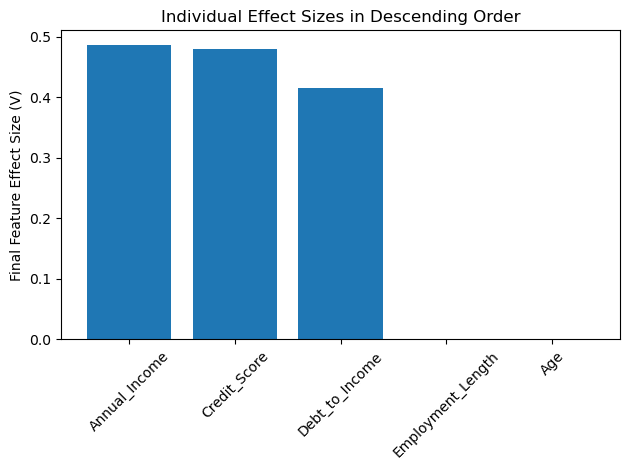

In [43]:
df_sorted = main_df.sort_values(by='Main Effect (r_pb)', ascending=False)
filtered_df = df_sorted[main_df['Main p-value'] < 0.05]
# Plot
plt.figure()
plt.bar(df_sorted['Feature'], df_sorted['Main Effect (r_pb)'])
plt.xticks(rotation=45)
plt.ylabel('Final Feature Effect Size (V)')
plt.title('Individual Effect Sizes in Descending Order')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, f"main_bar_.png"), dpi=300)
plt.show()

/var/folders/fg/p1v2zct14kndx3r29mnqvqkm0000gp/T/ipykernel_35567/4147356575.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = df_sorted[pairwise_df['Interaction p-value'] > 0.05]


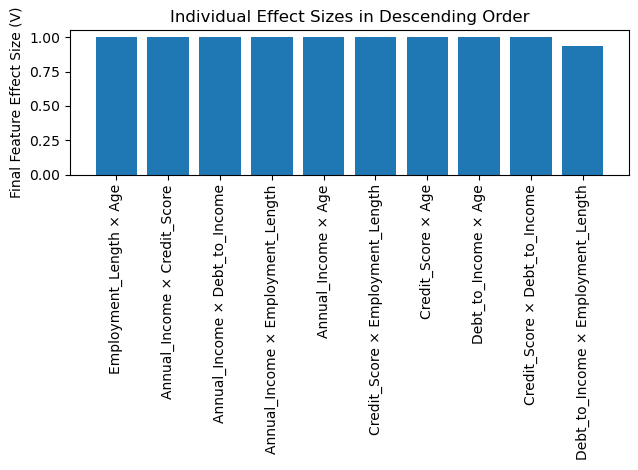

In [51]:
df_sorted = pairwise_df.sort_values(by='Effect Size (OR)', ascending=False)
filtered_df = df_sorted[pairwise_df['Interaction p-value'] < 0.05]
# Plot
plt.figure()
plt.bar(df_sorted['Feature Pair'], df_sorted['Effect Size (OR)'])
plt.xticks(rotation=90)
plt.ylabel('Final Feature Effect Size (V)')
plt.title('Individual Effect Sizes in Descending Order')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, f"pairwise_bar_.png"), dpi=300)
plt.show()

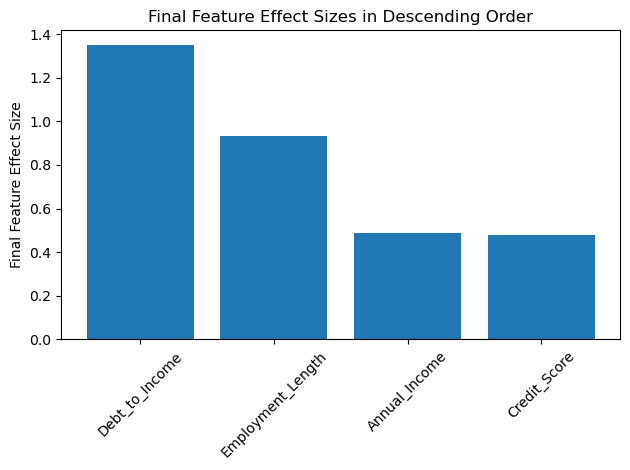

In [47]:
# final_results = pd.DataFrame(final_records)
df_sorted = final_df.sort_values(by='Final Score', ascending=False)
filtered_df = df_sorted[df_sorted['Final Score'] > 0.0]
# Plot
plt.figure()
plt.bar(filtered_df['Feature'], filtered_df['Final Score'])
plt.xticks(rotation=45)
plt.ylabel('Final Feature Effect Size')
plt.title('Final Feature Effect Sizes in Descending Order')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, f"final_bar_.png"), dpi=300)
plt.show()

## STAT‑XAI (Numeric): Tables & Plots

## (Optional) Feature‑Recovery Demo

In [53]:

# If you have ground truth for synthetic data, evaluate recovery
GT = set()  # e.g., {'Credit_Score','Annual_Income','Debt_to_Income'}
if GT:
    ranking = final_df['Feature'].tolist()
    def compute_feature_recovery_metrics(gt: Set[str], ranking: Sequence[str]) -> pd.DataFrame:
        tp = set(gt).intersection(ranking)
        fp = set(ranking).difference(gt)
        precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
        recall = len(tp) / len(gt) if len(gt) else 0.0
        fdr = len(fp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) else 0.0
        top1 = 1 if (len(ranking) > 0 and ranking[0] in gt) else 0
        return pd.DataFrame([{
            "Precision": precision, "Recall": recall, "FDR": fdr, "Top-1 Match": top1
        }])
    rec_df = compute_feature_recovery_metrics(GT, ranking)
    rec_df.insert(0, "Method", f"{MODEL_SUFFIX} + STAT-XAI")
    display(rec_df)
    rec_df.to_csv(os.path.join(TABLES_DIR, f"feature_recovery_metrics_{MODEL_SUFFIX}.csv"), index=False)


In [55]:

# === STAT-XAI (Verbatim Calc) for Numeric Features ===
# Uses merged_df (built above) to compute main, pairwise, and final metrics
# exactly as in the provided snippet.

numerical_cols = [c for c in merged_df.select_dtypes(include=[np.number]).columns if c != 'Predicted_Label']

alpha = 0.05

# === 1) MAIN EFFECTS via Point-Biserial Correlation ===
individual = []
main_effects = {}

for feat in numerical_cols:
    r_pb, p_val = pointbiserialr(merged_df[feat], merged_df['Predicted_Label'])
    effect = r_pb if p_val < alpha else 0.0
    main_effects[feat] = effect
    individual.append({
        'Feature': feat,
        'Main p-value': round(p_val, 4),
        'Main Effect (r_pb)': round(effect, 4)
    })

main_df = pd.DataFrame(individual)
display(main_df)

# === 2) PAIRWISE INTERACTIONS via Logistic Regression ===
pair_effects = {feat: 0.0 for feat in numerical_cols}
interaction_details = []

for x, y in itertools.combinations(numerical_cols, 2):
    try:
        formula = f"Predicted_Label ~ {x} * {y}"
        model = smf.logit(formula, merged_df).fit(disp=False)
        interaction_term = f"{x}:{y}"
        p_int = model.pvalues.get(interaction_term, np.nan)
        coef_int = model.params.get(interaction_term, np.nan)
        odds_ratio = np.exp(coef_int) if not np.isnan(coef_int) else np.nan
        significant = (p_int < alpha) if not np.isnan(p_int) else False

        interaction_details.append({
            'Feature Pair':        f"{x} × {y}",
            'Interaction p-value': round(p_int, 4) if not np.isnan(p_int) else np.nan,
            'Effect Size (OR)':    round(odds_ratio, 4) if not np.isnan(odds_ratio) else np.nan,
            'Significant?':        'Yes' if significant else 'No'
        })
        if significant and not np.isnan(odds_ratio):
            pair_effects[x] += odds_ratio
            pair_effects[y] += odds_ratio
    except Exception as e:
        interaction_details.append({
            'Feature Pair': f"{x} × {y}",
            'Interaction p-value': np.nan,
            'Effect Size (OR)': np.nan,
            'Significant?': 'NA'
        })

pairwise_df = pd.DataFrame(interaction_details)
display(pairwise_df)

# === 3) FINAL COMPOSITE SCORES ===
results = []
for feat in numerical_cols:
    sum_int = pair_effects[feat]
    main_eff = main_effects.get(feat, 0.0)
    results.append({
        'Feature':               feat,
        'Main Effect (r_pb)':    round(main_eff, 4),
        'Sum Interaction (ORs)': round(sum_int, 4),
        'Final Score':           round(main_eff + sum_int, 4)
    })

final_df = pd.DataFrame(results)
display(final_df)


,Feature,Main p-value,Main Effect (r_pb)
0,Annual_Income,0.0000,0.4865
1,Credit_Score,0.0000,0.4794
2,Debt_to_Income,0.0000,0.4157
3,Employment_Length,0.5114,0.0000
4,Age,0.1116,0.0000


,Feature Pair,Interaction p-value,Effect Size (OR),Significant?
0,Annual_Income × Credit_Score,0.7256,1.0000,No
1,Annual_Income × Debt_to_Income,0.2958,1.0000,No
2,Annual_Income × Employment_Length,0.8990,1.0000,No
3,Annual_Income × Age,0.7553,1.0000,No
4,Credit_Score × Debt_to_Income,0.4893,0.9989,No
5,Credit_Score × Employment_Length,0.7788,1.0000,No
6,Credit_Score × Age,0.7630,1.0000,No
7,Debt_to_Income × Employment_Length,0.0394,0.9348,Yes
8,Debt_to_Income × Age,0.9186,0.9990,No
9,Employment_Length × Age,0.5685,1.0002,No


,Feature,Main Effect (r_pb),Sum Interaction (ORs),Final Score
0,Annual_Income,0.4865,0.0000,0.4865
1,Credit_Score,0.4794,0.0000,0.4794
2,Debt_to_Income,0.4157,0.9348,1.3505
3,Employment_Length,0.0000,0.9348,0.9348
4,Age,0.0000,0.0000,0.0000
